In [ ]:
import torch
import torchvision.datasets as datasets
import torch.nn as nn 
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
mnistDataSet = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor()) 
trainSet , validationSet = torch.utils.data.random_split(mnistDataSet, [55000, 5000], generator=torch.Generator().manual_seed(42))
print(f"Eğitim seti: {len(trainSet)} adet")
print(f"Doğrulama seti: {len(validationSet)} adet")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Eğitim seti: 55000 adet
Doğrulama seti: 5000 adet


In [ ]:
loaders = {
    'train' : torch.utils.data.DataLoader(trainSet, 
                                          batch_size=256, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'validation'  : torch.utils.data.DataLoader(validationSet, 
                                          batch_size=256, 
                                          shuffle=True, 
                                          num_workers=1),
}

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(      
            in_channels=1,
            out_channels=64,
            kernel_size = 3,
            stride = 1,
            padding = 1,
          ),
          nn.PReLU(),
          nn.AvgPool2d(kernel_size = 2),
          
          nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size = 3,
            stride = 1,
            padding = 1,
          ),
          nn.PReLU(),
          nn.AvgPool2d(kernel_size = 2),
        )
        
        self.flatten = nn.Flatten(start_dim = 1)

        self.bottleneckFullyConnected = nn.Sequential(
          nn.Linear(128 * 7 * 7, 128),
          nn.PReLU(),
        )

    def forward(self, x):
      x = self.encoder(x)
      x = self.flatten(x)
      x = self.bottleneckFullyConnected(x)
      return x

In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    
    self.fullyConnected = nn.Sequential(
        nn.Linear(128, 128 * 7 * 7),   
        nn.PReLU(),
      )
    
    self.unflatten = nn.Unflatten(dim=1, 
    unflattened_size=(128, 7, 7))

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d( 
                in_channels=128,
                out_channels=128,
                kernel_size = 2,
                stride = 2,
                ),    
        nn.PReLU(),

        nn.Conv2d(
                in_channels=128,
                out_channels=64,
                kernel_size = 3,
                stride = 1,
                padding = 1
                ),
        nn.PReLU(),

        nn.ConvTranspose2d(
                in_channels=64,
                out_channels=64,
                kernel_size = 2,
                stride = 2,
                ),
        nn.PReLU(),
        
        nn.Conv2d(
                in_channels=64,
                out_channels=1,
                kernel_size = 3,
                stride = 1,
                padding = 1
        ),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.fullyConnected(x)
    x = self.unflatten(x)
    x = self.decoder(x)
    return x


In [ ]:
class ClassifierModel(nn.Module):
  def __init__(self):

    super(ClassifierModel, self).__init__()
    
    self.flatten = nn.Flatten(start_dim = 1)
    
    self.linearLayer = nn.Sequential(
        nn.Linear(128, 50),
        nn.PReLU(),
        nn.Linear(50, 10),   
        nn.Softmax(dim = 1)
    )
  
  def forward(self, x):
    x = self.flatten(x)
    output = self.linearLayer(x)
    return output

In [ ]:
def noiseAdd(inputs, noiseRate):
  imageSize = inputs.size()[1] * inputs.size()[2] 
  imageIndis = torch.randperm(imageSize)
  changeImageIndis=int(imageSize * noiseRate)
  indisedImage = []
  counter = 0
  index = 1

  returnedImage =  torch.randn_like(inputs) # pointer üzerinde değişim yapmamak için sadece görsel boyutu kadar 0 dizisi oluşturuldu.

  for i in range(0,changeImageIndis): # noise rate kadar piksel seçmek için 
    indisedImage.append(imageIndis[i]) 

  for i in range(0,len(returnedImage)):
    for j in range(0,len(returnedImage[i])):
      for k in range(0,len(returnedImage[i][j])):
        if(counter in indisedImage):
          if(index % 2 == 0):
            returnedImage[i][j][k] = 1
            index = index + 1
          else:
            returnedImage[i][j][k] = 0
            index = index + 1
        else:
          returnedImage[i][j][k] = inputs[i][j][k]
        counter = counter + 1

  return returnedImage

In [ ]:
def noiseAddMethod2(inputs, noiseRate):
  noisy = inputs + torch.randn_like(inputs) * noiseRate
  noisy = torch.clip(noisy,0.,1.)
  return noisy

noiseAddMethod2 bir diğer method olarak ekledim. Eğitim için **noiseAdd** kullanılmıştır.

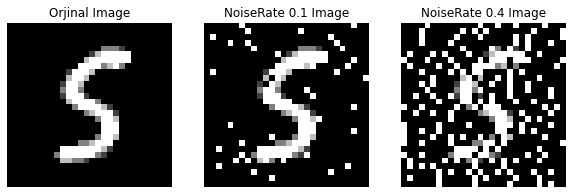

In [ ]:
image, label = next(iter(loaders['train']))
noiseImage1 = noiseAdd(image[0], 0.4)
noiseImage2 = noiseAdd(image[0], 0.1)


fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
fig.set_size_inches(10, 4)
ax1.axis('off')
ax1.set_title("Orjinal Image")
ax2.axis('off')
ax2.set_title("NoiseRate 0.1 Image")
ax3.axis('off')
ax3.set_title("NoiseRate 0.4 Image")
ax1.imshow(np.squeeze(image[0]), cmap='gray')
ax2.imshow(np.squeeze(noiseImage2), cmap='gray')
ax3.imshow(np.squeeze(noiseImage1), cmap='gray')


noiseAddMethod2 Sonucudur. Eğitimde kullanılmadı.




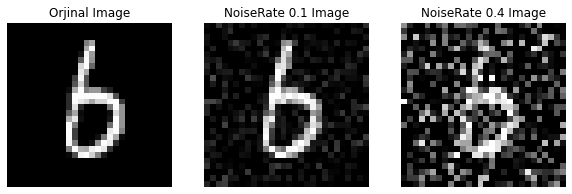

In [ ]:
image, label = next(iter(loaders['train']))
noiseImage1 = noiseAddMethod2(image[0], 0.4)
noiseImage2 = noiseAddMethod2(image[0], 0.1)

fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
fig.set_size_inches(10, 4)
ax1.axis('off')
ax1.set_title("Orjinal Image")
ax2.axis('off')
ax2.set_title("NoiseRate 0.1 Image")
ax3.axis('off')
ax3.set_title("NoiseRate 0.4 Image")
ax1.imshow(np.squeeze(image[0]), cmap='gray')
ax2.imshow(np.squeeze(noiseImage2), cmap='gray')
ax3.imshow(np.squeeze(noiseImage1), cmap='gray')

print("noiseAddMethod2 Sonucudur. Eğitimde kullanılmadı.\n\n")

In [ ]:
def trainAndValidationForAutoEncoders(loaders, learningRate, noiseRate):
  epochs  = 30

  trainLossList = []
  validLossList = []
  testAccuracyList = []

  encoder = Encoder().to(device)
  decoder = Decoder().to(device)

  params = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
  ]
  
  optim = torch.optim.SGD(params, lr = learningRate, momentum=0.9) 
  lossFunc = nn.MSELoss()

  print("Begin training...") 
  for epoch in range(epochs):
    runningTrainLoss = 0.0 
    runningValidationLoss = 0.0 
    testAcc = 0.0   

    encoder.train() 
    decoder.train() 
    for i, (images, labels) in enumerate(loaders['train']):

      imagesNoisy = noiseAdd(images, noiseRate)
      images, imagesNoisy, labels = images.to(device), imagesNoisy.to(device), labels.to(device)

      encodedData = encoder(imagesNoisy).to(device)
      decodedData = decoder(encodedData).to(device)

      loss = lossFunc(decodedData, images)
      runningTrainLoss += loss.item() / len(loaders['train'])

      optim.zero_grad() 
      loss.backward() 
      optim.step()

    
    trainLossList.append(runningTrainLoss)
    
    
    encoder.eval() 
    decoder.eval()  
    with torch.no_grad():
      for i, (images, labels) in enumerate(loaders['validation']):
        imagesNoisy = noiseAdd(images, noiseRate)
        images, imagesNoisy, labels = images.to(device), imagesNoisy.to(device), labels.to(device)

        encodedData = encoder(imagesNoisy).to(device)
        decodedData = decoder(encodedData).to(device)

        loss = lossFunc(decodedData, images)
        runningValidationLoss += loss.item() / len(loaders['validation'])

        acc = ((decodedData.argmax(dim=1) == images).float().mean())
        testAcc += acc / len(loaders['validation'])
      
      validLossList.append(runningValidationLoss)
      testAccuracyList.append(testAcc)

      if((epoch+1) % 5 == 0):
        print("AutoEncoder Epoch: {} / {}, TrainLoss (AutoEncoder): {}, ValidationLoss (AutoEncoder): {}, Accuracy (AutoEncoder): {}".format(epoch+1, epochs, trainLossList[-1], validLossList[-1], testAccuracyList[-1]))
      
  print("Finished training.") 

  return encoder, decoder, trainLossList, validLossList, testAccuracyList
    

In [ ]:
def trainAndValidationForClassifier(encoder, classifierModel, loaders, learningRate, noiseRate):
  epochs  = 30

  trainLossList = []
  validLossList = []
  testAccuracyList = []


  optim = torch.optim.SGD(classifierModel.parameters(), lr = learningRate, momentum=0.9) 
  lossFunc = nn.CrossEntropyLoss()

  print("Begin training...") 
  for epoch in range(epochs):
    runningTrainLoss = 0.0 
    runningValidationLoss = 0.0 
    testAcc = 0.0  

    encoder.eval()
    classifierModel.train() 
    for i, (images, labels) in enumerate(loaders['train']):

      imagesNoisy = noiseAdd(images, noiseRate)
      images, imagesNoisy, labels = images.to(device), imagesNoisy.to(device), labels.to(device)

      encodedData = encoder(imagesNoisy).to(device)
      classifierResult = classifierModel(encodedData).to(device)

      loss = lossFunc(classifierResult, labels)
      runningTrainLoss += loss.item() / len(loaders['train'])
      
      optim.zero_grad() 
      loss.backward() 
      optim.step()

    trainLossList.append(runningTrainLoss)
    
    encoder.eval()
    classifierModel.eval()  
    with torch.no_grad():
      for i, (images, labels) in enumerate(loaders['validation']):
        imagesNoisy = noiseAdd(images, noiseRate)
        images, imagesNoisy, labels = images.to(device), imagesNoisy.to(device), labels.to(device)

        encodedData = encoder(imagesNoisy).to(device)
        classifierResult = classifierModel(encodedData).to(device)

        loss = lossFunc(classifierResult, labels)
        runningValidationLoss += loss.item() / len(loaders['validation'])
        
        acc = ((classifierResult.argmax(dim=1) == labels).float().mean())
        testAcc += acc / len(loaders['validation'])
      
      
      validLossList.append(runningValidationLoss)
      testAccuracyList.append(testAcc)

      if((epoch+1) % 5 == 0):
        print("Classifier Epoch: {} / {}, TrainLoss (Classifier): {}, ValidationLoss (Classifier): {}, Accuracy (Classifier): {}".format(epoch+1, epochs, trainLossList[-1], validLossList[-1], testAccuracyList[-1]))
      
  print("Finished training.") 

  return classifierModel, trainLossList, validLossList, testAccuracyList
    

In [ ]:
noiseRate = [0.1, 0.4]

encoder01, decoder01, trainLossList01, validLossList01, testAccuracyList01 = trainAndValidationForAutoEncoders(loaders, 0.01, noiseRate[0])
classifierModel01 = ClassifierModel().to(device)
classifierModel01, trainLossListClassifier01, validLossListClassifier01, testAccuracyListClassifier01  = trainAndValidationForClassifier(encoder01, classifierModel01, loaders, 0.01, noiseRate[0])


encoder02, decoder02, trainLossList02, validLossList02, testAccuracyList02 = trainAndValidationForAutoEncoders(loaders, 0.01, noiseRate[1])
classifierModel02 = ClassifierModel().to(device)
classifierModel02, trainLossListClassifier02, validLossListClassifier02, testAccuracyListClassifier02 = trainAndValidationForClassifier(encoder02, classifierModel02, loaders, 0.01, noiseRate[1])


Begin training...
AutoEncoder Epoch: 5 / 30, TrainLoss (AutoEncoder): 0.09646101905856024, ValidationLoss (AutoEncoder): 0.09624570496380329, Accuracy (AutoEncoder): 0.8088051080703735
AutoEncoder Epoch: 10 / 30, TrainLoss (AutoEncoder): 0.09573736565057629, ValidationLoss (AutoEncoder): 0.09544423371553422, Accuracy (AutoEncoder): 0.8090239763259888
AutoEncoder Epoch: 15 / 30, TrainLoss (AutoEncoder): 0.09512637579856913, ValidationLoss (AutoEncoder): 0.09502712078392506, Accuracy (AutoEncoder): 0.8087382316589355
AutoEncoder Epoch: 20 / 30, TrainLoss (AutoEncoder): 0.09453394333290494, ValidationLoss (AutoEncoder): 0.09437233693897723, Accuracy (AutoEncoder): 0.8088186383247375
AutoEncoder Epoch: 25 / 30, TrainLoss (AutoEncoder): 0.09398894251085994, ValidationLoss (AutoEncoder): 0.09383200705051421, Accuracy (AutoEncoder): 0.808883547782898
AutoEncoder Epoch: 30 / 30, TrainLoss (AutoEncoder): 0.09353756984305932, ValidationLoss (AutoEncoder): 0.09349999092519286, Accuracy (AutoEncod

In [1]:
epochs = range(1,31)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4)
fig.set_size_inches(25, 8)
fig.suptitle('Training and Validation Loss')
ax1.plot(epochs, trainLossList01, label='Training Loss')
ax1.plot(epochs,validLossList01, label='Validation Loss')
ax1.set_title('Autoencoder Gürültü Oranı: 0.1')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_xticks(np.arange(0, 30, 2))
ax1.legend(loc='best')

ax3.plot(epochs, trainLossListClassifier01, label='Training Loss')
ax3.plot(epochs,validLossListClassifier01, label='Validation Loss')
ax3.set_title('Classifier Gürültü Oranı: 0.1')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.set_xticks(np.arange(0, 30, 2))
ax3.legend(loc='best')

ax2.plot(epochs, trainLossList02, label='Training Loss')
ax2.plot(epochs,validLossList02, label='Validation Loss')
ax2.set_title('Autoencoder Gürültü Oranı: 0.4')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_xticks(np.arange(0, 30, 2))
ax2.legend(loc='best')

ax4.plot(epochs, trainLossListClassifier02, label='Training Loss')
ax4.plot(epochs,validLossListClassifier02, label='Validation Loss')
ax4.set_title('Classifier Gürültü Oranı: 0.4')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Loss')
ax4.set_xticks(np.arange(0, 30, 2))
ax4.legend(loc='best')

NameError: ignored